In [1]:
import pandas as pd, numpy as np, time
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    f1_score, roc_auc_score
)
import matplotlib.pyplot as plt


In [4]:
PATH = Path("places_cleaned.parquet")
assert PATH.exists(), f"Missing cleaned file: {PATH}"

df = pd.read_parquet(PATH)
print("Loaded:", df.shape)
print(df.head(3))

expected_cols = [
    "label","name","base_name",
    "address","base_address",
    "website","base_website",
    "phone","base_phone"
]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

print("\nMissing rates (%):")
print((df[expected_cols].isna().mean()*100).round(2))

print("\nEmpty-string rates (%):")
print(((df[expected_cols].astype(str)=="").mean()*100).round(2))

print("\nLabel balance:")
print(df["label"].value_counts(normalize=True).round(3))

Loaded: (2731, 13)
   label                                id                           base_id  \
0    1.0  08f391ab10c7114d033517ea0e3905a9                   562949956772225   
1    0.0  08f26ed44c0f20f103c3e3cc6e5bed37                  1407374886409435   
2    0.0  08f2a100d649b2940358781f0b0c6078  08f2a10725b1451a03d80f18dbf3f667   

                              name                                 address  \
0                               bp  avenida carlos cano | los barrios | es   
1         northwest medical center  609 w maple ave | springdale | ar | us   
2  manhattan hardware & housewares        688 9th ave | new york | ny | us   

                                             website         phone  \
0  https://map.bp.com/es-es/es/estacion-de-servic...  +34956621050   
1                    http://www.northwesthealth.com/  +14797515711   
2              https://twitter.com/#!/9thavehardware  +12127574555   

                                   base_name  \
0                 

In [7]:
X_left  = df["name"].astype(str).tolist()
X_right = df["base_name"].astype(str).tolist()
y = df["label"].astype(int).values

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

def encode_with_latency(texts):
    t0 = time.perf_counter()
    E = model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)
    ms = (time.perf_counter() - t0)*1000/len(texts)
    return E, ms

E1, ms1 = encode_with_latency(X_left)
E2, ms2 = encode_with_latency(X_right)
latency_ms = (ms1 + ms2)/2
print(f"\nEncode latency ≈ {latency_ms:.1f} ms/query")

sims = (E1 * E2).sum(axis=1)  # cosine since normalized

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rows = []
for tr, te in skf.split(sims, y):
    ths = np.linspace(0.3, 0.9, 61)
    best_t, best_f1 = 0.5, -1
    for t in ths:
        f1 = f1_score(y[tr], (sims[tr] >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    yhat = (sims[te] >= best_t).astype(int)
    acc = accuracy_score(y[te], yhat)
    p, r, f1, _ = precision_recall_fscore_support(y[te], yhat, average="binary", zero_division=0)
    s = sims[te]; s = (s - s.min())/(s.max()-s.min()+1e-9)
    auc = roc_auc_score(y[te], s)
    rows.append((best_t, acc, p, r, f1, auc))

res_minilm = pd.DataFrame(rows, columns=["best_t","acc","prec","rec","f1","auc"])
print("\nMiniLM 3-fold results:")
print(res_minilm.round(3))
print("Averages:", res_minilm.mean().round(3).to_dict())

res_minilm.assign(model="MiniLM-L6-v2", enc_ms_per_query=latency_ms)\
          .to_csv("minilm_results.csv", index=False)
print("Saved → minilm_results.csv")



Encode latency ≈ 0.4 ms/query

MiniLM 3-fold results:
   best_t    acc   prec    rec     f1    auc
0    0.72  0.727  0.742  0.838  0.787  0.799
1    0.72  0.712  0.720  0.852  0.781  0.805
2    0.72  0.752  0.753  0.874  0.809  0.823
Averages: {'best_t': 0.72, 'acc': 0.73, 'prec': 0.738, 'rec': 0.854, 'f1': 0.792, 'auc': 0.809}
Saved → minilm_results.csv


In [8]:
try:
    model_e5 = SentenceTransformer("intfloat/e5-small-v2")
    def enc_e5(texts):
        t0 = time.perf_counter()
        E = model_e5.encode(texts, convert_to_numpy=True, normalize_embeddings=True)
        ms = (time.perf_counter() - t0)*1000/len(texts)
        return E, ms

    E1e5, ms1e5 = enc_e5(X_left)
    E2e5, ms2e5 = enc_e5(X_right)
    latency_ms_e5 = (ms1e5 + ms2e5)/2
    sims_e5 = (E1e5 * E2e5).sum(axis=1)

    rows = []
    for tr, te in skf.split(sims_e5, y):
        ths = np.linspace(0.3, 0.9, 61)
        best_t, best_f1 = 0.5, -1
        for t in ths:
            f1 = f1_score(y[tr], (sims_e5[tr] >= t).astype(int))
            if f1 > best_f1:
                best_f1, best_t = f1, t
        yhat = (sims_e5[te] >= best_t).astype(int)
        acc = accuracy_score(y[te], yhat)
        p, r, f1, _ = precision_recall_fscore_support(y[te], yhat, average="binary", zero_division=0)
        s = sims_e5[te]; s = (s - s.min())/(s.max()-s.min()+1e-9)
        auc = roc_auc_score(y[te], s)
        rows.append((best_t, acc, p, r, f1, auc))

    res_e5 = pd.DataFrame(rows, columns=["best_t","acc","prec","rec","f1","auc"])
    print("\nE5-small-v2 3-fold results:")
    print(res_e5.round(3))
    print("Averages:", res_e5.mean().round(3).to_dict())

    res_e5.assign(model="E5-small-v2", enc_ms_per_query=latency_ms_e5)\
           .to_csv("e5_results.csv", index=False)
    print("Saved → e5_results.csv")
except Exception as e:
    print("E5 baseline skipped:", e)


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]


E5-small-v2 3-fold results:
   best_t    acc   prec    rec     f1    auc
0     0.9  0.706  0.701  0.892  0.785  0.806
1     0.9  0.700  0.692  0.901  0.783  0.812
2     0.9  0.735  0.722  0.910  0.805  0.829
Averages: {'best_t': 0.9, 'acc': 0.714, 'prec': 0.705, 'rec': 0.901, 'f1': 0.791, 'auc': 0.816}
Saved → e5_results.csv



Summary:
           model       acc        f1  enc_ms_per_query
0   E5-small-v2  0.713661  0.791082          0.636986
1  MiniLM-L6-v2  0.730137  0.792000          0.416334


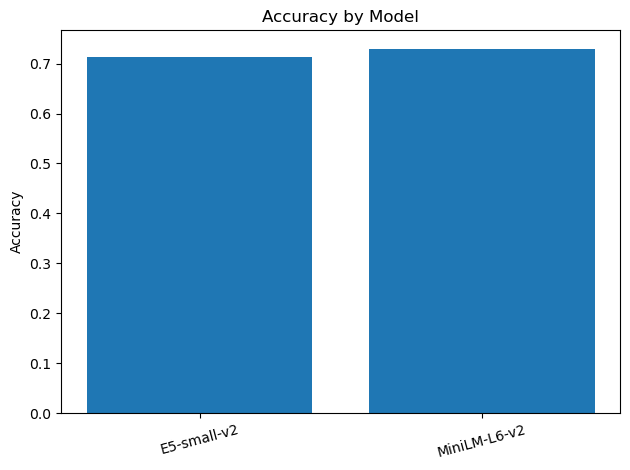

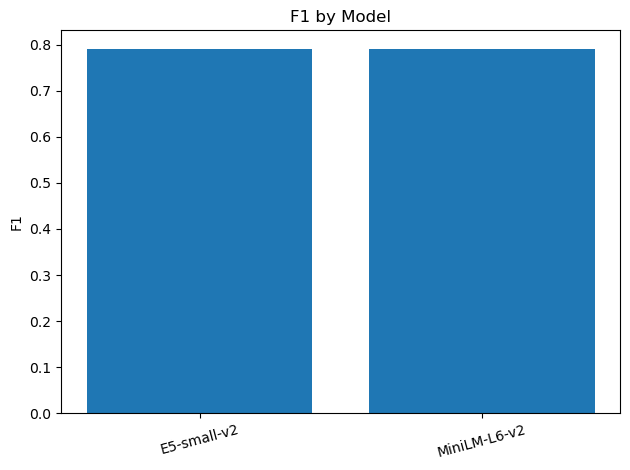

In [10]:
import matplotlib.pyplot as plt, os
dfs=[]
for f in ["minilm_results.csv","e5_results.csv"]:
    if os.path.exists(f):
        dfs.append(pd.read_csv(f))
if dfs:
    R = pd.concat(dfs, ignore_index=True)
    summary = R.groupby("model", as_index=False)[["acc","f1","enc_ms_per_query"]].mean()
    print("\nSummary:\n", summary)
    plt.figure()
    plt.bar(summary["model"], summary["acc"])
    plt.title("Accuracy by Model")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig("accuracy_by_model.png", dpi=150)
    plt.show()

    plt.figure()
    plt.bar(summary["model"], summary["f1"])
    plt.title("F1 by Model")
    plt.ylabel("F1")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig("f1_by_model.png", dpi=150)
    plt.show()
else:
    print("No results to plot yet.")